In [1]:
import pandas as pd
import numpy as np

from my_modules.transform import get_transform
from my_modules.model import MyModel
from my_modules.dataset import ClusterTestDataset, EvalDataset

import torch
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
from PIL import Image

In [9]:
import pickle
with open('pkl/psedo_age2.pkl', 'rb') as f:
    age_pred = pickle.load(f)

In [3]:
device='cuda'
model = MyModel('efficientnet-b0').to(device)
model.load_state_dict(torch.load('/opt/ml/code/save/cluster/log9_3.pt'))
model.eval()
print('model ready')

Loaded pretrained weights for efficientnet-b0
model ready


In [4]:
# get transform

transform = get_transform(augment=False, crop=350, resize=224, cutout=None)

In [5]:
# get datafraame

df_key = pd.read_csv('df/df_labled_train.csv')
df_query =pd.read_csv('/opt/ml/input/data/eval/info.csv')

In [6]:
# get dataset

ds_key = ClusterTestDataset(df_key, transform)
ds_query = EvalDataset(df_query, transform)

In [7]:
# get dataloader

dataloader_key = DataLoader(ds_key, batch_size=64, shuffle=False, num_workers=3)
dataloader_query = DataLoader(ds_query, batch_size=64, shuffle=False, num_workers=3)

In [8]:
# create keys

model.create_keys(dataloader_query, device)

100%|██████████| 197/197 [00:24<00:00,  7.99it/s]


In [10]:
import os
# ensemble prediction

df = df_query
n_neighbors = 5
y_pred = age_pred
# y_true = result['y_true']
ensembled_y_pred = []

img_path_ = '/opt/ml/input/data/eval/images'

for i in tqdm(range(len(df))):
    
    #y_true.append(df.iloc[i]['age'])
    
    a = [0, 0, 0]
    
    image_path = os.path.join(img_path_, df['ImageID'].iloc[i])
    img = Image.open(image_path)
    #img = Image.open(df.iloc[i]['path'])
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        queries = model.eff(img).cpu().numpy()

    groups_idx = model.query(queries, n_neighbors)[0]

    for idx in groups_idx:
        a[y_pred[idx]] += 1
    
    ensembled_y_pred.append(np.argmax(a))

# f1 = f1_score(y_true, ensembled_y_pred, average='macro')
# acc = accuracy_score(y_true, ensembled_y_pred)

# print(f'acc:{acc:.4f}, f1:{f1:.4f}')

100%|██████████| 12600/12600 [06:33<00:00, 32.05it/s]


In [11]:
disagree = []

for i in range(len(df)):
    if age_pred[i] != ensembled_y_pred[i]:
        disagree.append(i)

disagree

[18,
 42,
 49,
 120,
 163,
 168,
 171,
 177,
 178,
 227,
 279,
 381,
 420,
 432,
 448,
 475,
 520,
 633,
 651,
 672,
 688,
 736,
 766,
 808,
 854,
 861,
 865,
 902,
 932,
 943,
 948,
 960,
 982,
 1169,
 1177,
 1208,
 1242,
 1294,
 1336,
 1354,
 1374,
 1424,
 1425,
 1437,
 1537,
 1558,
 1654,
 1677,
 1679,
 1683,
 1715,
 1725,
 1766,
 1796,
 1812,
 1824,
 1872,
 1899,
 1914,
 1933,
 2036,
 2062,
 2063,
 2159,
 2188,
 2207,
 2212,
 2271,
 2326,
 2334,
 2366,
 2400,
 2433,
 2463,
 2482,
 2483,
 2496,
 2513,
 2516,
 2612,
 2632,
 2639,
 2670,
 2702,
 2711,
 2717,
 2736,
 2741,
 2784,
 2815,
 2847,
 2848,
 2930,
 2971,
 3016,
 3022,
 3050,
 3090,
 3148,
 3179,
 3194,
 3198,
 3211,
 3264,
 3287,
 3313,
 3396,
 3409,
 3453,
 3458,
 3510,
 3536,
 3551,
 3640,
 3680,
 3697,
 3731,
 3773,
 3867,
 3926,
 3942,
 3957,
 3984,
 3985,
 3986,
 3996,
 4067,
 4078,
 4236,
 4261,
 4299,
 4302,
 4304,
 4325,
 4392,
 4465,
 4499,
 4576,
 4603,
 4614,
 4650,
 4695,
 4777,
 4785,
 4789,
 4806,
 4809,
 4838,


In [12]:
from PIL import Image
import os

In [15]:
i = -1
gender=['young', 'middle', 'old']

24/391  before : old, after : middle


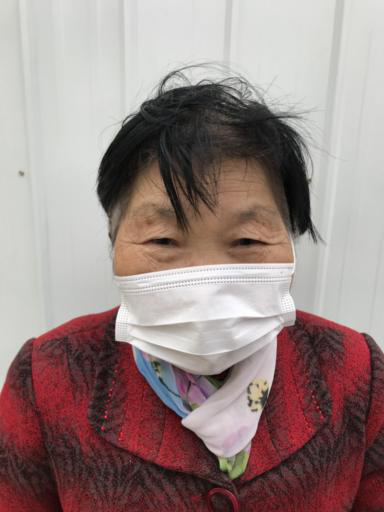

In [40]:
i += 1
idx = disagree[i]
print(f'{i+1}/{len(disagree)}  before : {gender[age_pred[idx]]}, after : {gender[ensembled_y_pred[idx]]}')
img = Image.open(os.path.join('/opt/ml/input/data/eval/images', df.iloc[idx]['ImageID']))
img

In [ ]:
before : 18
after : 12
? b2 a1

In [8]:
# Key / Query

In [25]:
with open('pkl/ensembled_age5_2.pkl', 'wb') as f:
    pickle.dump(ensembled_y_pred, f)

In [27]:
# ensemble prediction

df = df_key
n_neighbors = 5
weights = 1.0 / (df_key.age.value_counts().sort_index().to_numpy())**0.25
y_pred = []
y_true = []

for i in tqdm(range(len(df))):
    
    y_true.append(df.iloc[i]['age'])
    
    a = [0, 0, 0]
    
    img = Image.open(df.iloc[i]['path'])
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        queries = model.eff(img).cpu().numpy()

    groups_idx = model.query(queries, n_neighbors)[0]

    for idx in groups_idx:
        pred_idx = df_key['age'].iloc[idx]
        a[pred_idx] += 1

    y_pred.append(np.argmax(a))

f1 = f1_score(y_true, y_pred, average='macro')
acc = accuracy_score(y_true, y_pred)

print(f'acc:{acc:.4f}, f1:{f1:.4f}')

100%|██████████| 15120/15120 [04:53<00:00, 51.57it/s]

acc:0.4329, f1:0.3266


In [ ]:
# fig, axes = plt.subplots(1, n + 1, figsize=(15, 5))
# axes[0].imshow(img_pil)
# axes[0].axis('off')
# axes[0].set_title('query')

# for ax, i in zip(axes[1:], groups_idx):
#     img = Image.open(df_key.iloc[i]['path'])
#     ax.imshow(img)
#     ax.axis('off')
#     ax.set_title(df_key.iloc[i]['gender'])

# plt.show()